## Kaggle - Regression of Used Car Prices

This notebook is part of the Kaggle competition for predicting used car prices through regression. In this notebook, I have completed data cleaning and added several new features. After that, I used Optuna to identify the best features for LightGBM (LGB), XGBoost (XGB), and Random Forest (RF) models. Among these, LGB provided the best predictions. Following this, I implemented a stacking approach to further improve the model’s performance, but it resulted in similar outcomes to using LGB alone.

I would greatly appreciate any feedback you may have on the notebook.


### Importing Libraries

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import re
import statsmodels
import statsmodels.api as sm
import lightgbm as lgbe

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, StackingRegressor, VotingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, RandomizedSearchCV, cross_val_score

import shap 
import warnings
warnings.filterwarnings('ignore')

In [89]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [90]:
df_train.shape, df_test.shape

((188533, 13), (125690, 12))

In [91]:
df_train.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


In [92]:
df_train.drop('id', axis=1, inplace=True)
id = df_test['id']
df_test.drop('id', axis=1, inplace=True)

In [93]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   brand         188533 non-null  object
 1   model         188533 non-null  object
 2   model_year    188533 non-null  int64 
 3   milage        188533 non-null  int64 
 4   fuel_type     183450 non-null  object
 5   engine        188533 non-null  object
 6   transmission  188533 non-null  object
 7   ext_col       188533 non-null  object
 8   int_col       188533 non-null  object
 9   accident      186081 non-null  object
 10  clean_title   167114 non-null  object
 11  price         188533 non-null  int64 
dtypes: int64(3), object(9)
memory usage: 17.3+ MB


In [94]:
df_train.describe()

,model_year,milage,price
count,188533.000000,188533.000000,1.885330e+05
mean,2015.829998,65705.295174,4.387802e+04
std,5.660967,49798.158076,7.881952e+04
min,1974.000000,100.000000,2.000000e+03
25%,2013.000000,24115.000000,1.700000e+04
50%,2017.000000,57785.000000,3.082500e+04
75%,2020.000000,95400.000000,4.990000e+04
max,2024.000000,405000.000000,2.954083e+06


### Exploratory Data Analysis

In [95]:
null_columns_perc = 100*((df_train.isnull().sum())/len(df_train))
null_columns_perc

brand            0.000000
model            0.000000
model_year       0.000000
milage           0.000000
fuel_type        2.696080
engine           0.000000
transmission     0.000000
ext_col          0.000000
int_col          0.000000
accident         1.300568
clean_title     11.360876
price            0.000000
dtype: float64

In [96]:
df_train['fuel_type'].unique()

array(['Gasoline', 'E85 Flex Fuel', nan, 'Hybrid', 'Diesel',
       'Plug-In Hybrid', '–', 'not supported'], dtype=object)

In [97]:
df_train['accident'].unique()

array(['None reported', 'At least 1 accident or damage reported', nan],
      dtype=object)

In [98]:
df_train['accident'].value_counts()

accident
None reported                             144514
At least 1 accident or damage reported     41567
Name: count, dtype: int64

In [99]:
df_train['clean_title'].unique()

array(['Yes', nan], dtype=object)

In [100]:
# Handle missing values and replace specific categories
def preprocess_data(df):  
    df['fuel_type'] = df['fuel_type'].fillna('None')
    df['fuel_type'] = df['fuel_type'].replace({'–': 'none', 'not supported': 'none'})
    
    df['accident'] = df['accident'].fillna('None reported')
    
    df['clean_title'] = df['clean_title'].fillna('No')
    
    return df


In [101]:
df_train = preprocess_data(df_train)
df_test = preprocess_data(df_test)

In [102]:
null_columns_perc = 100*((df_train.isnull().sum())/len(df_train))
null_columns_perc

brand           0.0
model           0.0
model_year      0.0
milage          0.0
fuel_type       0.0
engine          0.0
transmission    0.0
ext_col         0.0
int_col         0.0
accident        0.0
clean_title     0.0
price           0.0
dtype: float64

In [103]:
for column in df_train.columns:
    print(column, df_train[column].nunique())

brand 57
model 1897
model_year 34
milage 6651
fuel_type 7
engine 1117
transmission 52
ext_col 319
int_col 156
accident 2
clean_title 2
price 1569


In [104]:
def age_features(df):
    df['Vehicle_Age'] = 2024 - df['model_year'] # how much old is the vehicle
    df['Milage_Per_Year'] = df['milage'] / df['Vehicle_Age'] # milage per each year
    df['Milage_With_Age'] = df.groupby('Vehicle_Age')['milage'].transform('mean') # mean of vehicle age and milage
    df['Milage_Per_Year_With_Age'] = df.groupby('Vehicle_Age')['Milage_Per_Year'].transform('mean') # mean of milage per year and age

    return df

df_train = age_features(df_train)
df_test = age_features(df_test)

In [105]:
categorical_columns = df_train.select_dtypes(include=['object', 'category']).columns

In [106]:
categorical_columns

Index(['brand', 'model', 'fuel_type', 'engine', 'transmission', 'ext_col',
       'int_col', 'accident', 'clean_title'],
      dtype='object')

In [107]:
def visualize_unique_values(df, categorical_columns):
    for column in categorical_columns:
        unique_vals = df[column].unique()
        print(f"\nColumn: {column}")
        print(f"Unique values ({len(unique_vals)}): {unique_vals}\n")

# Call the function for the training data
visualize_unique_values(df_train, categorical_columns)


Column: brand
Unique values (57): ['MINI' 'Lincoln' 'Chevrolet' 'Genesis' 'Mercedes-Benz' 'Audi' 'Ford'
 'BMW' 'Tesla' 'Cadillac' 'Land' 'GMC' 'Toyota' 'Hyundai' 'Volvo'
 'Volkswagen' 'Buick' 'Rivian' 'RAM' 'Hummer' 'Alfa' 'INFINITI' 'Jeep'
 'Porsche' 'McLaren' 'Honda' 'Lexus' 'Dodge' 'Nissan' 'Jaguar' 'Acura'
 'Kia' 'Mitsubishi' 'Rolls-Royce' 'Maserati' 'Pontiac' 'Saturn' 'Bentley'
 'Mazda' 'Subaru' 'Ferrari' 'Aston' 'Lamborghini' 'Chrysler' 'Lucid'
 'Lotus' 'Scion' 'smart' 'Karma' 'Plymouth' 'Suzuki' 'FIAT' 'Saab'
 'Bugatti' 'Mercury' 'Polestar' 'Maybach']


Column: model
Unique values (1897): ['Cooper S Base' 'LS V8' 'Silverado 2500 LT' ... 'e-Golf SE'
 'Integra w/A-Spec Tech Package' 'IONIQ Plug-In Hybrid SEL']


Column: fuel_type
Unique values (7): ['Gasoline' 'E85 Flex Fuel' 'None' 'Hybrid' 'Diesel' 'Plug-In Hybrid'
 'none']


Column: engine
Unique values (1117): ['172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel'
 '252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel'
 '320.0HP 5.3L 8 Cyli

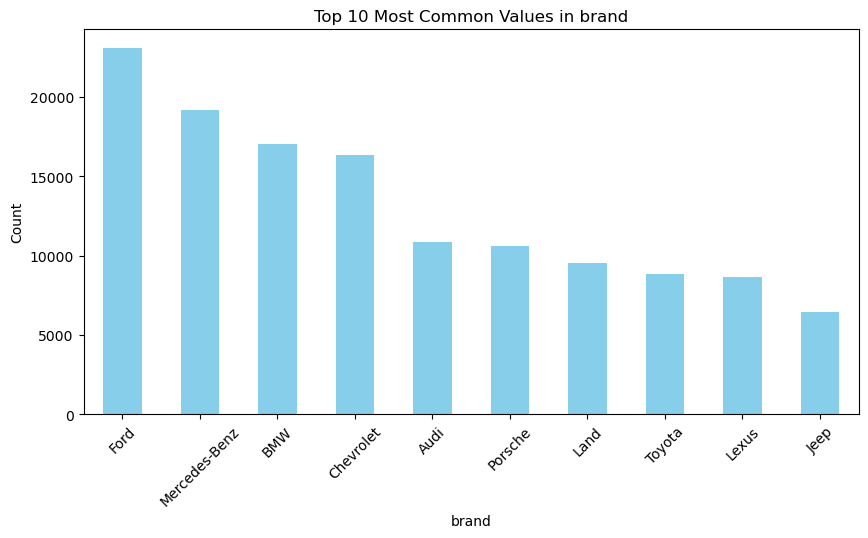

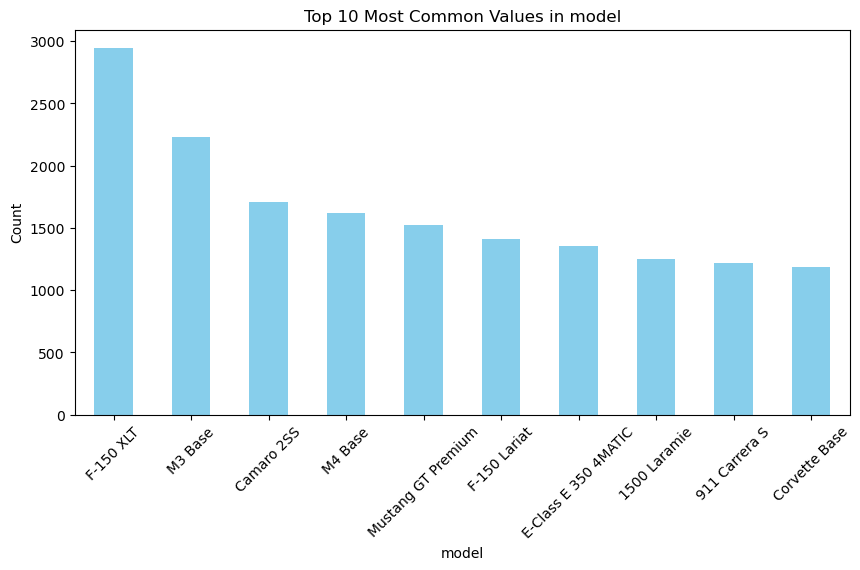

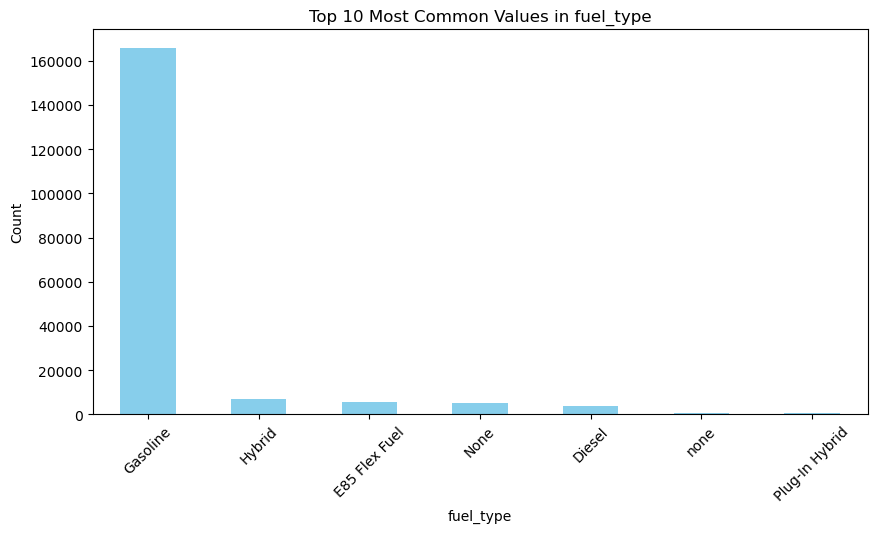

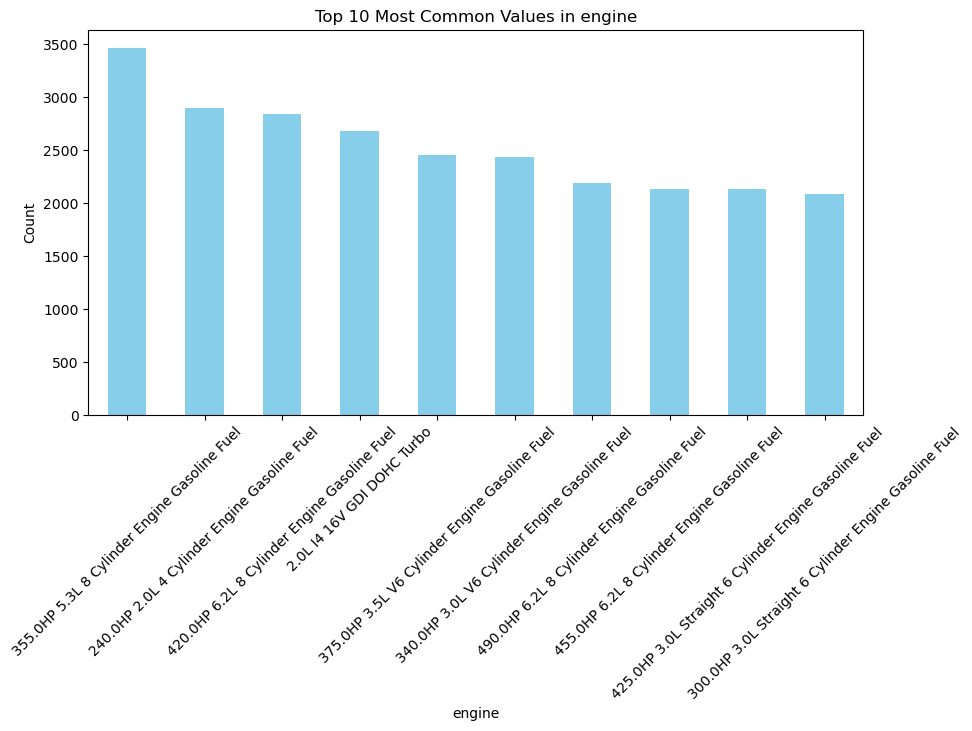

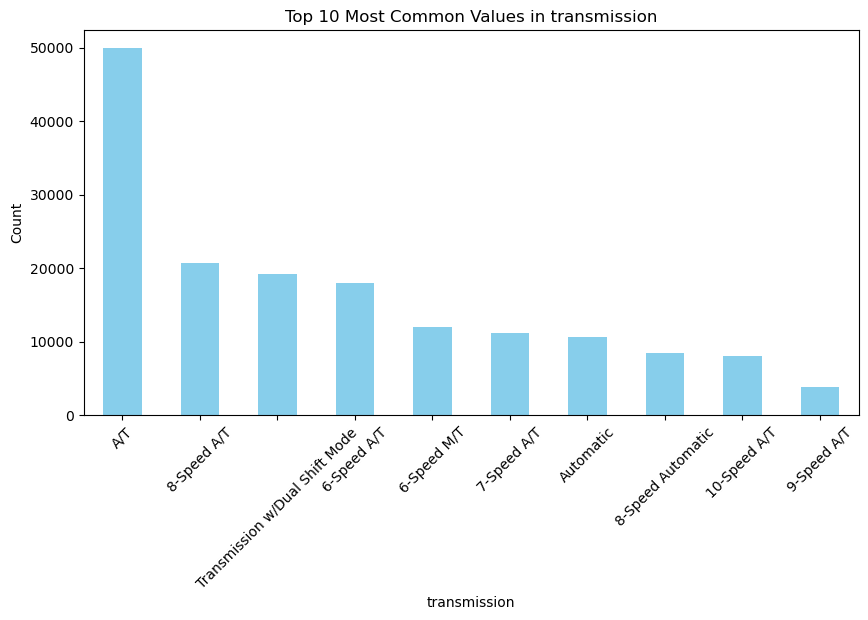

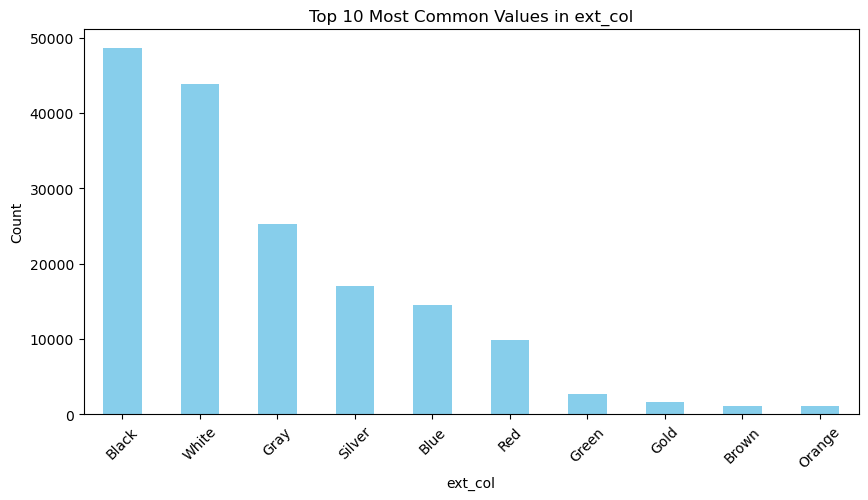

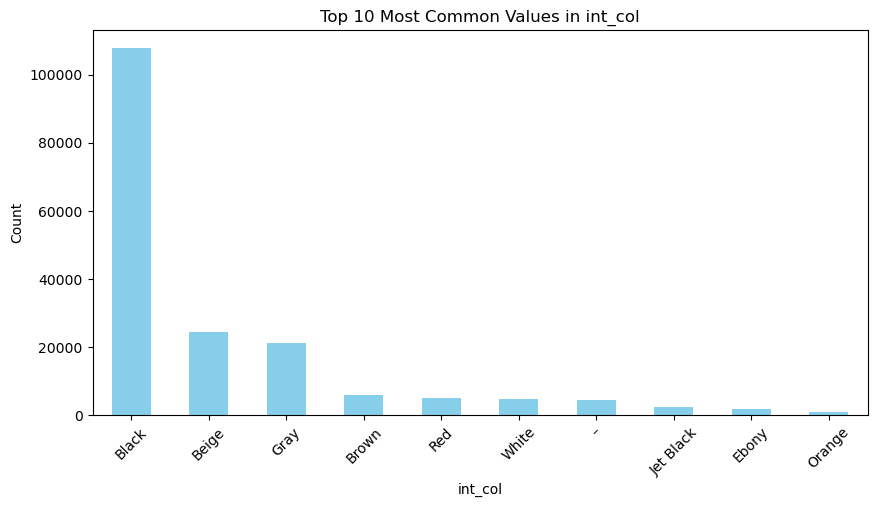

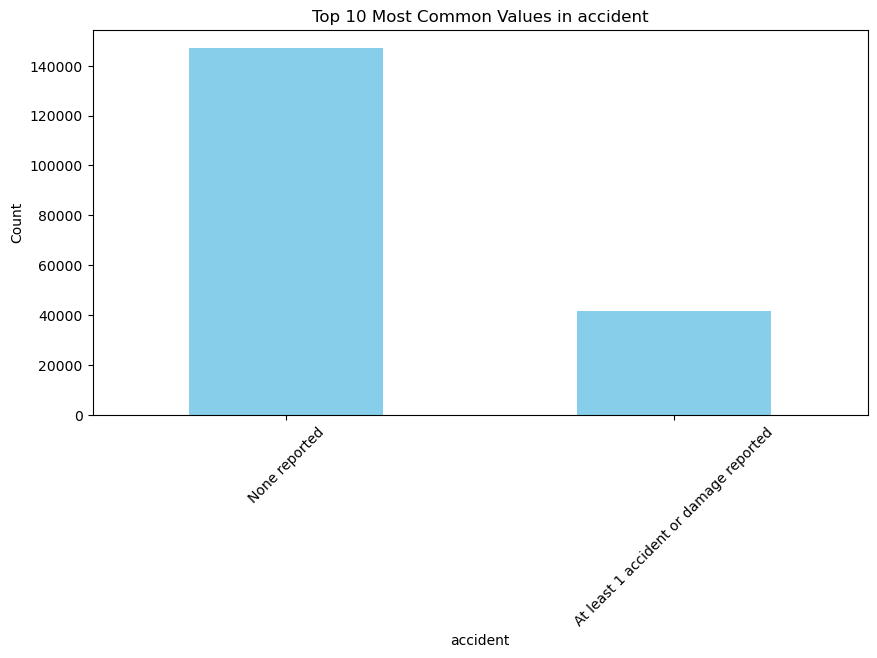

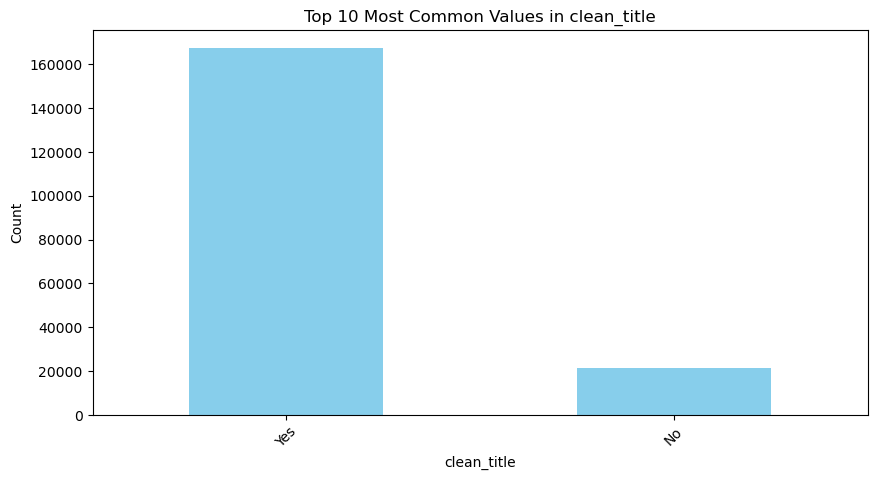

In [108]:
def visualize_top_10_categorical(df, categorical_columns):
    for column in categorical_columns:
        plt.figure(figsize=(10, 5))
        top_10_values = df[column].value_counts().head(10)
        
        top_10_values.plot(kind='bar', color='skyblue')
        plt.title(f'Top 10 Most Common Values in {column}')
        plt.xlabel(column)
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.show()

# Call the function to plot the top 10 distributions for training data
visualize_top_10_categorical(df_train, categorical_columns)


In [109]:
def luxury_features(df):
    luxury_brands =  ['Mercedes-Benz', 'BMW', 'Audi', 'Porsche', 'Land', 
                        'Lexus', 'Jaguar', 'Bentley', 'Maserati', 'Lamborghini', 
                        'Rolls-Royce', 'Ferrari', 'McLaren', 'Aston', 'Maybach']
    df['Is_Luxury_Brand'] = df['brand'].apply(lambda x: 1 if x in luxury_brands else 0) # 1 if the car is luxury or not
    
    return df

df_train = luxury_features(df_train)
df_test = luxury_features(df_test)

In [110]:
def age_features(df):
    df['Vehicle_Age'] = 2024 - df['model_year'] # how much old is the vehicle
    df['Milage_Per_Year'] = df['milage'] / df['Vehicle_Age'] # milage per each year
    df['Milage_With_Age'] = df.groupby('Vehicle_Age')['milage'].transform('mean') # mean of vehicle age and milage
    df['Milage_Per_Year_With_Age'] = df.groupby('Vehicle_Age')['Milage_Per_Year'].transform('mean') # mean of milage per year and age

    return df

df_train = age_features(df_train)
df_test = age_features(df_test)

In [111]:
def clean_transform_transmission(df):
    df['transmission'] = df['transmission'].replace({
        '7-Speed A/T': 'A/T',
        '6 Speed At/Mt': 'At/Mt',
        '8-Speed A/T': 'A/T',
        '10-Speed Automatic': 'A/T',
        '1-Speed A/T': 'A/T',
        '6-Speed A/T': 'A/T',
        '10-Speed A/T': 'A/T',
        '9-Speed A/T': 'A/T',
        '8-Speed Automatic': 'A/T',
        '9-Speed Automatic': 'A/T',
        '5-Speed A/T': 'A/T',
        'Automatic': 'A/T',
        '7-Speed Automatic with Auto-Shift': 'A/T',
        'CVT Transmission': 'CVT',
        '5-Speed M/T': 'M/T',
        '6-Speed M/T': 'M/T',
        '6-Speed Automatic': 'A/T',
        '4-Speed Automatic': 'A/T',
        '7-Speed M/T': 'M/T',
        '2-Speed A/T': 'A/T',
        '1-Speed Automatic': 'A/T',
        'Automatic CVT': 'CVT',
        '4-Speed A/T': 'A/T',
        '6-Speed Manual': 'M/T',
        'Transmission Overdrive Switch': 'A/T',
        '8-Speed Automatic with Auto-Shift': 'A/T',
        '7-Speed Manual': 'M/T',
        '7-Speed Automatic': 'A/T',
        '9-Speed Automatic with Auto-Shift': 'A/T',
        '6-Speed Automatic with Auto-Shift': 'A/T',
        '6 Speed Mt': 'M/T',
        '6-Speed Electronically Controlled Automatic with O': 'A/T',
        'F': 'NN',
        'CVT-F': 'CVT',
        '8-Speed Manual': 'M/T',
        'Manual': 'M/T',
        'Single-Speed Fixed Gear': 'M/T',
        '8-SPEED AT': 'A/T',
        '5-Speed Automatic': 'A/T',
        '2-Speed Automatic': 'A/T',
        '8-SPEED A/T': 'A/T',
        '10-Speed Automatic with Overdrive': 'A/T',
        '7-Speed DCT Automatic': 'A/T',
        'SCHEDULED FOR OR IN PRODUCTION': 'NN',
        '6-Speed': 'NN',
        'Transmission Overdrive Switch': 'NN',
        '2': 'NN',
        '7-Speed': 'NN',
        '–': 'NN',
        'At/Mt': 'NN'  
    })

    return df

# Apply the function to the training and testing data
df_train = clean_transform_transmission(df_train)
df_test = clean_transform_transmission(df_test)


In [112]:
df_train['transmission'].value_counts()

transmission
A/T                                                   49904
8-Speed A/T                                           20645
Transmission w/Dual Shift Mode                        19255
6-Speed A/T                                           18044
6-Speed M/T                                           11998
7-Speed A/T                                           11124
Automatic                                             10691
8-Speed Automatic                                      8431
10-Speed A/T                                           8044
9-Speed A/T                                            3866
5-Speed A/T                                            3217
10-Speed Automatic                                     3164
6-Speed Automatic                                      2799
4-Speed A/T                                            2546
5-Speed M/T                                            2409
9-Speed Automatic                                      2325
CVT Transmission           

In [113]:
def group_colors(color):
    color = color.lower().strip()  # Normalize case and remove leading/trailing spaces
    
    if 'black' in color:
        return 'black'
    elif 'white' in color or 'pearl' in color:
        return 'white'
    elif 'blue' in color:
        return 'blue'
    elif 'red' in color:
        return 'red'
    elif 'gray' in color or 'grey' in color:
        return 'gray'
    elif 'silver' in color:
        return 'silver'
    elif 'green' in color:
        return 'green'
    elif 'yellow' in color:
        return 'yellow'
    elif 'brown' in color:
        return 'brown'
    elif 'beige' in color or 'gold' in color:
        return 'beige'
    elif 'purple' in color or 'plum' in color:
        return 'purple'
    elif 'orange' in color:
        return 'orange'
    else:
        return 'other'  # Group less common colors into 'other'

# Apply this function to the 'ext_col' column
df_train['ext_col'] = df_train['ext_col'].apply(group_colors)
df_train['int_col'] = df_train['int_col'].apply(group_colors)
df_test['ext_col'] = df_test['ext_col'].apply(group_colors)
df_test['int_col'] = df_test['int_col'].apply(group_colors)


In [114]:
df_train['ext_col'].value_counts()

ext_col
black     53917
white     49060
gray      26763
silver    18809
blue      15695
red       11399
other      3477
green      2948
beige      2764
brown      1185
orange     1148
yellow      994
purple      374
Name: count, dtype: int64

In [115]:
df_train['int_col'].value_counts()

int_col
black     112677
beige      25173
gray       21589
other      10147
brown       6006
red         5507
white       4916
orange       969
blue         855
silver       429
green        214
yellow        51
Name: count, dtype: int64

In [116]:
df_train['engine'].value_counts()

engine
355.0HP 5.3L 8 Cylinder Engine Gasoline Fuel           3462
240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel           2902
420.0HP 6.2L 8 Cylinder Engine Gasoline Fuel           2841
2.0L I4 16V GDI DOHC Turbo                             2680
375.0HP 3.5L V6 Cylinder Engine Gasoline Fuel          2451
                                                       ... 
151.0HP 1.5L 4 Cylinder Engine Gas/Electric Hybrid        1
184.0HP 2.4L 4 Cylinder Engine Flex Fuel Capability       1
78.0HP 1.2L 3 Cylinder Engine Gasoline Fuel               1
139.0HP 1.6L 4 Cylinder Engine Plug-In Electric/Gas       1
313.0HP 2.0L 4 Cylinder Engine Plug-In Electric/Gas       1
Name: count, Length: 1117, dtype: int64

In [117]:
# Function to extract the necessary components from the 'engine' column
def extract_engine_features_without_fuel(engine_str):
    # Extract horsepower
    hp_match = re.search(r'(\d+(\.\d+)?HP)', engine_str)
    horsepower = float(hp_match.group(1).replace('HP', '')) if hp_match else None

    # Extract engine size in liters
    engine_size_match = re.search(r'(\d+(\.\d+)?L)', engine_str)
    engine_size = float(engine_size_match.group(1).replace('L', '')) if engine_size_match else None

    # Extract number of cylinders
    cylinder_match = re.search(r'(\d+) Cylinder', engine_str)
    cylinders = int(cylinder_match.group(1)) if cylinder_match else None

    return horsepower, engine_size, cylinders

# Apply the function to the 'engine' column without extracting fuel type
df_train[['horsepower', 'engine_size', 'cylinders']] = df_train['engine'].apply(
    lambda x: pd.Series(extract_engine_features_without_fuel(x))
)

df_test[['horsepower', 'engine_size', 'cylinders']] = df_test['engine'].apply(
    lambda x: pd.Series(extract_engine_features_without_fuel(x))
)

# Check the result
print(df_train[['engine', 'horsepower', 'engine_size', 'cylinders']].head())


In [118]:
df_train['Power_To_Weight_Ratio'] = df_train['horsepower'] / df_train['engine_size']
df_test['Power_To_Weight_Ratio'] = df_test['horsepower'] / df_test['engine_size']

In [119]:
df_train = df_train.drop('engine', axis=1)
df_test = df_test.drop('engine', axis=1)

In [120]:
null_columns_perc = 100*((df_train.isnull().sum())/len(df_train))
null_columns_perc

brand                       0.0
model                       0.0
model_year                  0.0
milage                      0.0
fuel_type                   0.0
engine                      0.0
transmission                0.0
ext_col                     0.0
int_col                     0.0
accident                    0.0
clean_title                 0.0
price                       0.0
Vehicle_Age                 0.0
Milage_Per_Year             0.0
Milage_With_Age             0.0
Milage_Per_Year_With_Age    0.0
Is_Luxury_Brand             0.0
dtype: float64

In [121]:
def fill_missing_values(df):
    df['horsepower'].fillna(df['horsepower'].mode()[0], inplace=True)
    df['engine_size'].fillna(df['engine_size'].mode()[0], inplace=True)
    df['cylinders'].fillna(df['cylinders'].mode()[0], inplace=True)
    df['Power_To_Weight_Ratio'].fillna(df['Power_To_Weight_Ratio'].mode()[0], inplace=True)
    return df

df_train = fill_missing_values(df_train)
df_test = fill_missing_values(df_test)

In [122]:
null_columns_perc = 100*((df_train.isnull().sum())/len(df_train))
null_columns_perc

brand                       0.0
model                       0.0
model_year                  0.0
milage                      0.0
fuel_type                   0.0
engine                      0.0
transmission                0.0
ext_col                     0.0
int_col                     0.0
accident                    0.0
clean_title                 0.0
price                       0.0
Vehicle_Age                 0.0
Milage_Per_Year             0.0
Milage_With_Age             0.0
Milage_Per_Year_With_Age    0.0
Is_Luxury_Brand             0.0
dtype: float64

In [123]:
numerical_columns = df_train.select_dtypes(include=['int64', 'float64']).columns
numerical_columns

Index(['model_year', 'milage', 'price', 'Vehicle_Age', 'Milage_Per_Year',
       'Milage_With_Age', 'Milage_Per_Year_With_Age', 'Is_Luxury_Brand'],
      dtype='object')

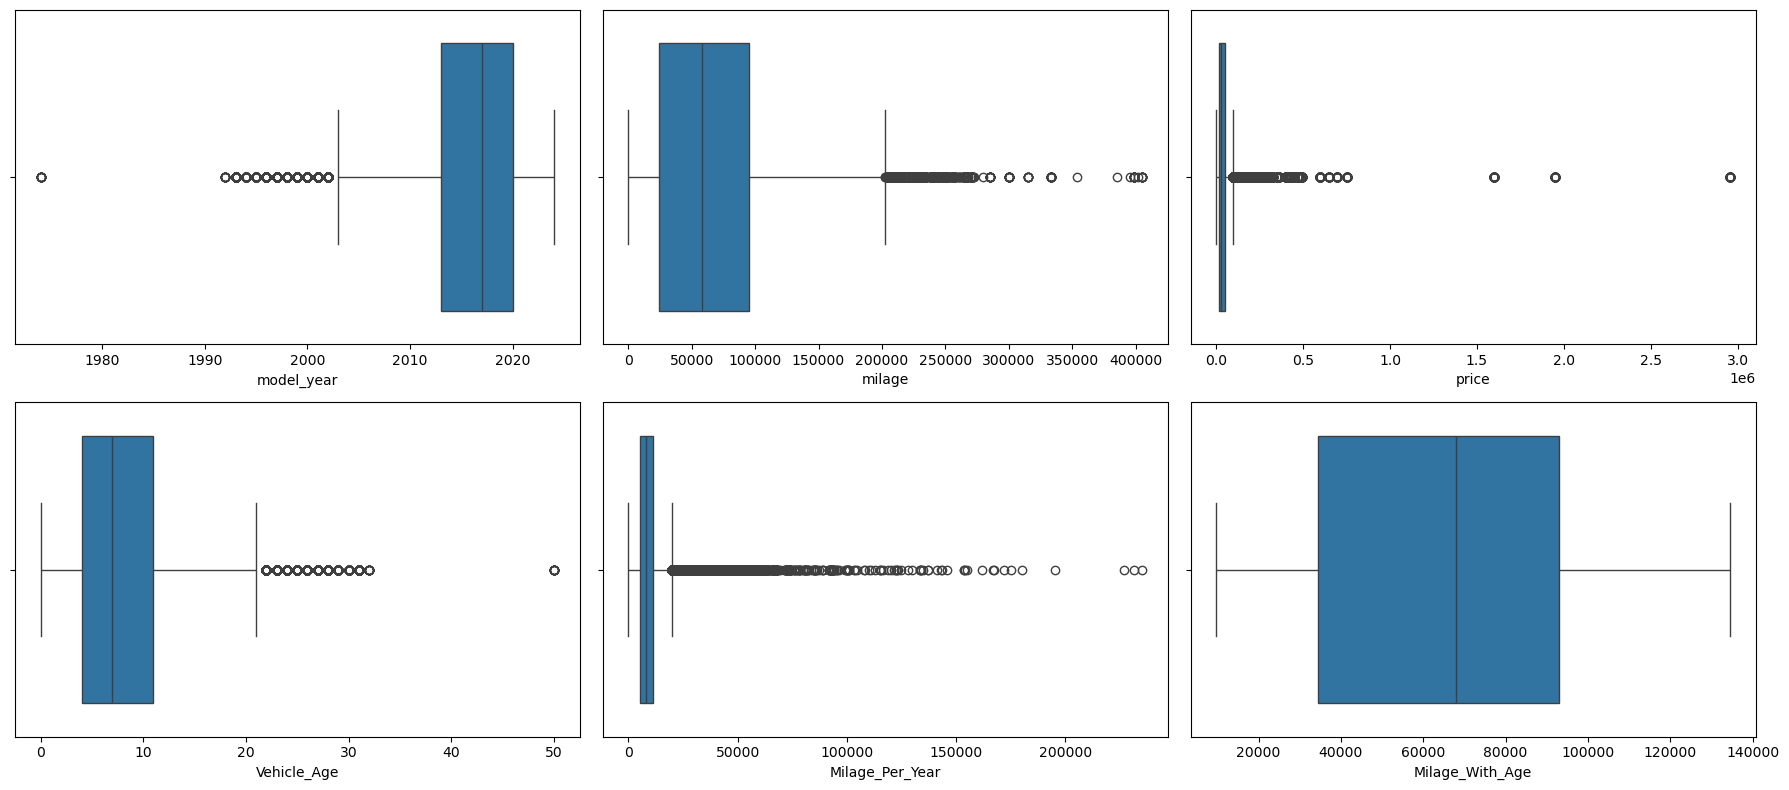

In [124]:
fig, ax = plt.subplots(2, 3, figsize=(18, 8))  # 2 rows and 3 columns for 6 plots

for i, column in enumerate(numerical_columns[:6]):  # Limit to 6 columns
    sns.boxplot(x=df_train[column], ax=ax[i // 3, i % 3])  # Use i // 3 for rows and i % 3 for columns

plt.tight_layout()  # Adjust layout for all subplots
plt.show() 

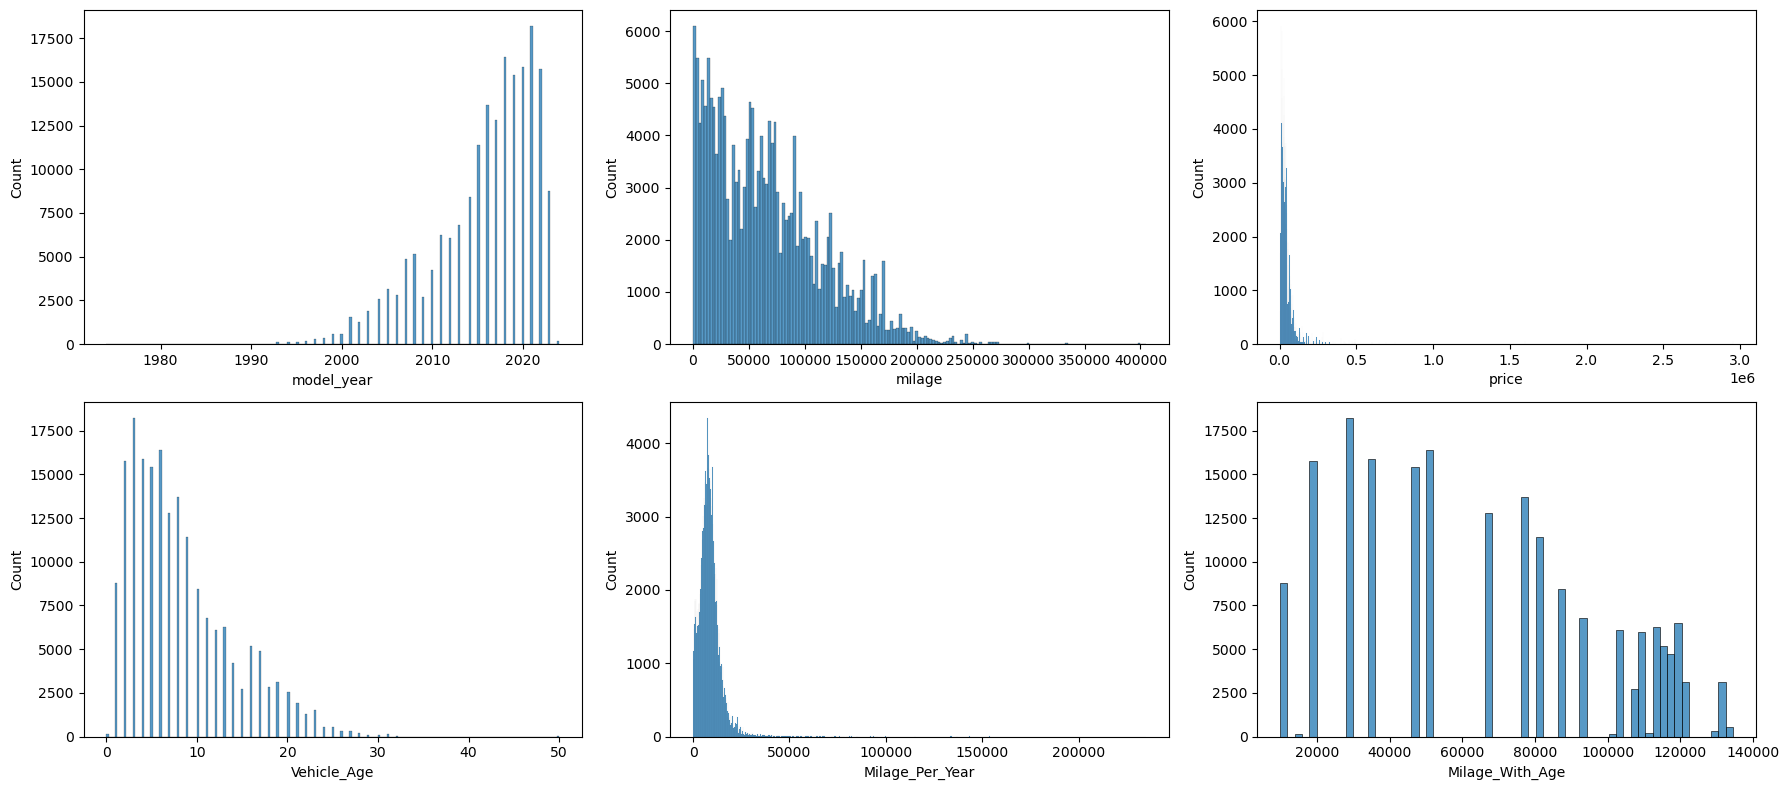

In [125]:
fig, ax = plt.subplots(2, 3, figsize=(18, 8))  # 2 rows and 3 columns for 6 plots

for i, column in enumerate(numerical_columns[:6]):  # Limit to 6 columns
    sns.histplot(x=df_train[column], ax=ax[i // 3, i % 3])  # Use i // 3 for rows and i % 3 for columns

plt.tight_layout()  # Adjust layout for all subplots
plt.show() 

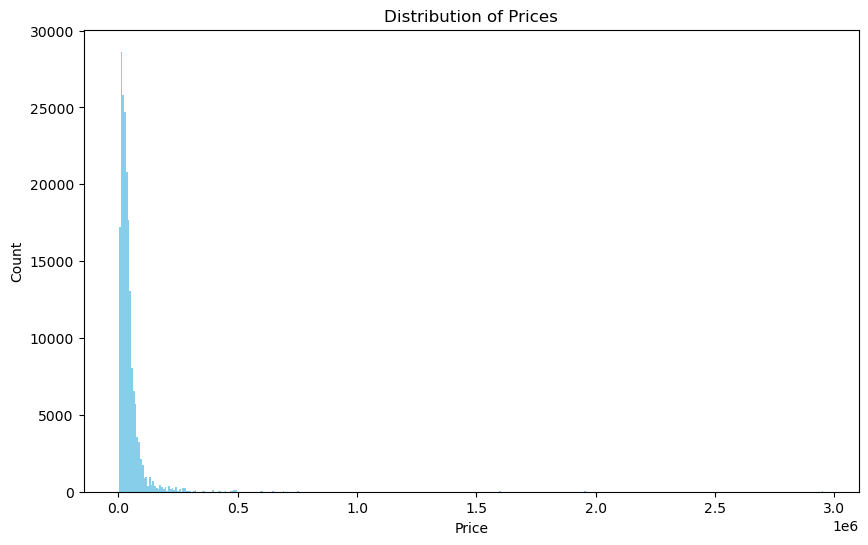

In [126]:
plt.figure(figsize=(10, 6))
plt.hist(df_train['price'], bins=400, color='skyblue')
plt.title('Distribution of Prices')
plt.xlabel('Price')
plt.ylabel('Count')
plt.show()

In [127]:
categorical_columns = df_train.select_dtypes(include=['object', 'category']).columns
categorical_columns

Index(['brand', 'model', 'fuel_type', 'engine', 'transmission', 'ext_col',
       'int_col', 'accident', 'clean_title'],
      dtype='object')

In [128]:
numerical_columns = numerical_columns.drop('price')
numerical_columns

Index(['model_year', 'milage', 'Vehicle_Age', 'Milage_Per_Year',
       'Milage_With_Age', 'Milage_Per_Year_With_Age', 'Is_Luxury_Brand'],
      dtype='object')

In [129]:
# Define a transformer class to remove outliers from specified numerical columns
class Outlier_rem(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # No fitting necessary for outlier removal, return self
        return self
    
    def transform(self, X):
        # List of numerical columns to apply outlier removal
        numcol = numerical_columns
        
        # Iterate over each numerical column
        for col in numcol:
            # Calculate the interquartile range (IQR)
            q1 = X[col].quantile(0.25)
            q3 = X[col].quantile(0.75)
            iqr = q3 - q1
            
            # Define lower and upper bounds for outliers
            lwr = q1 - (1.5 * iqr)
            upr = q3 + (1.5 * iqr)
            
            # Apply the lower bound: Replace values below the lower bound with the lower bound
            X[col] = X[col].apply(lambda x: lwr if x < lwr else x)
            
            # Apply the upper bound: Replace values above the upper bound with the upper bound
            X[col] = X[col].apply(lambda x: upr if x > upr else x)
        
        return X

# Define a transformer class to encode categorical features using LabelEncoder
class encoding(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # No fitting necessary for label encoding, return self
        return self
    
    def transform(self, X):
        le = LabelEncoder()
        # Iterate over the columns that need encoding 
        for col in categorical_columns:
            # Apply label encoding to the column
            X[col] = le.fit_transform(X[col])
        return X

# Define a transformer class to scale numerical features using StandardScaler
class Scaling(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # No fitting necessary for scaling, return self
        return self
    
    def transform(self, X):
        sc = StandardScaler()
        # Check if the dataset contains the target column 'price'
        if 'price' in X.columns:
            # Scale all columns except 'price'
            for col in X.columns:
                if col != 'price':
                    X[col] = sc.fit_transform(X[[col]])
        else:
            # Scale all columns in the dataset
            for col in X.columns:
                X[col] = sc.fit_transform(X[[col]])
        return X

In [130]:
# Create a pipeline that chains together several preprocessing steps
pipeline = Pipeline([
    ('Outlier', Outlier_rem()),         # Remove outliers by capping them at 1.5 times the IQR
    ('encoding', encoding()),           # Encode categorical features using LabelEncoder
    ('scaling', Scaling())              # Scale numerical features using StandardScaler
])

In [131]:
df_train = pipeline.fit_transform(df_train)
df_test_copy = df_test.copy()
df_test = pipeline.transform(df_test)

<Axes: >

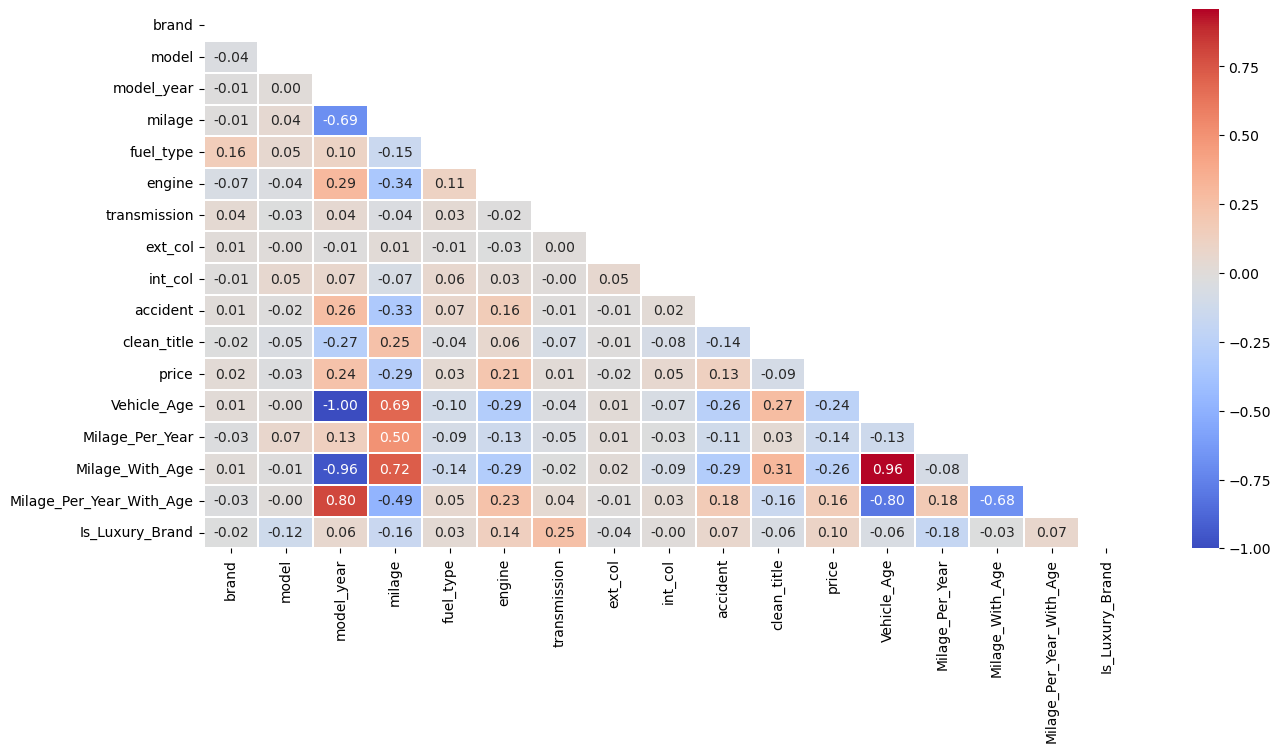

In [132]:
plt.figure(figsize=(15,7))
corr=df_train.corr()
mask=np.triu(corr)
sns.heatmap(corr,mask=mask,linewidth=0.1,annot=True,cmap='coolwarm',fmt='.2f')

In [133]:
X = df_train.drop('price', axis=1)
y = df_train['price']

In [134]:
X.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,Vehicle_Age,Milage_Per_Year,Milage_With_Age,Milage_Per_Year_With_Age,Is_Luxury_Brand
0,0.493978,-0.713392,-1.635482,2.808937,-0.075887,-1.786099,0.640494,1.450997,0.785395,0.531822,0.358008,1.635482,0.900888,1.487596,-1.942901,-0.872544
1,0.304919,0.120255,-2.461952,1.597038,-0.075887,-0.887343,0.640494,0.985462,-0.860682,-1.880330,0.358008,2.461952,-0.406204,1.486329,-1.942901,-0.872544
2,-0.892449,1.356353,-2.461952,1.463309,-1.773263,0.097693,0.640494,-0.876677,0.785395,0.531822,0.358008,2.461952,-0.470563,1.486329,-1.942901,-0.872544
3,-0.451314,-0.209371,0.201118,-0.941534,-0.075887,0.899383,1.486165,-1.109444,-0.449163,0.531822,0.358008,-0.201118,-1.215397,0.062968,1.101376,-0.872544
4,0.809075,0.401970,0.935758,-1.189996,-0.075887,-1.272010,-0.512694,-1.109444,-0.860682,0.531822,0.358008,-0.935758,-1.285561,-1.024190,1.195276,1.146075


In [135]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
param = {
        'learning_rate': 0.017521301504983752,
        'max_depth': 42,
        'reg_alpha': 0.06876635751774487, 
        'reg_lambda': 9.738899198284985,
        'num_leaves': 131,
        'subsample': 0.2683765421728044,
        'colsample_bytree': 0.44346036599709887,
        'n_estimators': 1000,
        'random_state': 42
    }

In [ ]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

lgb_model = LGBMRegressor(**param, verbose=-1, n_jobs=-1)

meta_model = Ridge(alpha=1.0)

In [ ]:
# Create a stacking regressor with Random Forest and LightGBM as base models
stacking_regressor = StackingRegressor(
    estimators=[('rf', rf_model), ('lgb', lgb_model)],
    final_estimator=meta_model,
    cv=5  # Use 5-fold cross-validation for stacking
)

In [ ]:
# Fit the stacking model
stacking_regressor.fit(X_train, y_train)

# Make predictions and evaluate the stacked model
y_pred = stacking_regressor.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2_score = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"Stacking RMSE: {rmse:.4f}")
print(f"Stacking R2 Score: {r2_score:.4f}")
print(f"Stacking MAE: {mae:.4f}")

In [ ]:
y_model_pred = stacking_regressor.predict(df_test)

submission = pd.DataFrame({'id': id, 'price': y_model_pred})

submission.to_csv('submission.csv', index=False)

### Found a very nice article for comparing performance of regression algorithms

https://gursev-pirge.medium.com/comparison-of-regression-analysis-algorithms-db710b6d7528

In [ ]:
# Optuna Objective Function for LightGBM
def objective_lgb(trial):
    param = {
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),
        'max_depth': trial.suggest_int('max_depth', 5, 50),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-4, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-4, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'subsample': trial.suggest_uniform('subsample', 0.2, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.2, 1.0),
        'n_estimators': 1000,
        'random_state': 42
    }

    model = LGBMRegressor(**param, verbose=-1, n_jobs=-1)
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    neg_mse = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
    
    return neg_mse.mean()

In [ ]:
# Optuna Objective Function for Random Forest
def objective_rf(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 5, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'random_state': 42,
        'n_jobs': -1
    }

    model = RandomForestRegressor(**param)
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    neg_mse = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
    
    return neg_mse.mean()

In [ ]:
# Define the objective function for optimization
def objective(trial):
    param = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 10, 50),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'booster': trial.suggest_categorical('booster', ['gbtree']),
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
    }

    model = XGBRegressor(**param, random_state=42)
    score = cross_val_score(model, X, y, cv=5).mean()
    return score

In [ ]:
# Create Optuna studies to optimize hyperparameters
study_lgb = optuna.create_study(direction='maximize')
study_lgb.optimize(objective_lgb, n_trials=50, timeout=1800)  # Adjust n_trials and timeout

study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective_rf, n_trials=50, timeout=1200)  # Adjust n_trials and timeout

study_xgb = optuna.create_study(direction="minimize")
study_xgb.optimize(objective, n_trials=10)

# Get the best hyperparameters from the Optuna studies
best_params_lgb = study_lgb.best_params
best_params_rf = study_rf.best_params
best_params_xgb = study_xgb.best_params

In [136]:
best_params_lgb = {
    'learning_rate': 0.006579840203227364,
    'max_depth': 35,
    'reg_alpha': 0.08149331095218464,
    'reg_lambda': 5.948638201136381,
    'num_leaves': 68,
    'subsample': 0.9138024995794776,
    'colsample_bytree': 0.2754380513412665
    }


In [137]:
param = {
        'learning_rate': 0.017521301504983752,
        'max_depth': 42,
        'reg_alpha': 0.06876635751774487, 
        'reg_lambda': 9.738899198284985,
        'num_leaves': 131,
        'subsample': 0.2683765421728044,
        'colsample_bytree': 0.44346036599709887,
        'n_estimators': 1000,
        'random_state': 42
    }

In [138]:
best_params_rf = {
    'n_estimators': 712,
    'max_depth': 9,
    'min_samples_split': 10,
    'min_samples_leaf': 10
}

In [139]:
best_params_xgb = {
    'learning_rate': 0.03026642852233556, 
    'num_leaves': 61, 
    'n_estimators': 439, 
    'max_depth': 22, 
    'min_child_samples': 60, 
    'subsample': 0.8511179772722972, 
    'colsample_bytree': 0.6765485831273763, 
    'booster': 'gbtree'
}

In [140]:
# Initialize models with the best parameters from Optuna
model_LGB = LGBMRegressor(**param, verbose=-1, n_jobs=-1)
model_RF = RandomForestRegressor(**best_params_rf, random_state=42, n_jobs=-1)

# Initialize the meta-model (e.g., Ridge Regression)
meta_model = XGBRegressor(**best_params_xgb, n_jobs=-1)

# Create a stacking regressor with Random Forest and LightGBM as base models
stacking_regressor = StackingRegressor(
    estimators=[('lgb', model_LGB), ('rf', model_RF)],
    final_estimator=meta_model,
    cv=5  # Use 5-fold cross-validation for stacking
)

In [141]:
# Perform KFold cross-validation for the combined model
kf = KFold(n_splits=5, shuffle=True, random_state=42)
train_scores = []
val_scores = []

In [142]:
for fold, (train_index, val_index) in enumerate(kf.split(X), 1):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Fitting the stacked model
    stacking_regressor.fit(X_train, y_train)

    # Predicting on training and validation sets
    y_train_pred = stacking_regressor.predict(X_train)
    y_val_pred = stacking_regressor.predict(X_val)

    # RMSE scores
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

    train_scores.append(train_rmse)
    val_scores.append(val_rmse)

    print(f"Fold {fold}: Train RMSE = {train_rmse:.4f}, Validation RMSE = {val_rmse:.4f}")

# Mean RMSE scores
mean_train_rmse = np.mean(train_scores)
mean_val_rmse = np.mean(val_scores)

print(f"\nMean Train RMSE: {mean_train_rmse:.4f}")
print(f"Mean Validation RMSE: {mean_val_rmse:.4f}")

Fold 1: Train RMSE = 71045.0722, Validation RMSE = 68260.1252
Fold 2: Train RMSE = 70502.9545, Validation RMSE = 69063.0029
Fold 3: Train RMSE = 69104.3792, Validation RMSE = 74197.6697
Fold 4: Train RMSE = 68740.1099, Validation RMSE = 76629.3157
Fold 5: Train RMSE = 68745.3721, Validation RMSE = 76737.3235

Mean Train RMSE: 69627.5776
Mean Validation RMSE: 72977.4874


In [143]:
# Fit the stacking model
y_model_pred = stacking_regressor.predict(df_test)

# Create a submission DataFrame
submission = pd.DataFrame({'id': id, 'price': y_model_pred})

# Save the submission DataFrame to a CSV file
submission.to_csv('submission9.csv', index=False)